## Principal Moments of Inertia

In [1]:
import os
import time

import numpy as np
import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem
from rdkit.Chem import PandasTools, rdDistGeom, rdForceFieldHelpers, rdMolDescriptors

In [2]:
BASE_PATH = os.path.dirname(os.getcwd())

In [3]:
files = [f for f in os.listdir(os.path.join(BASE_PATH, "data", "processed")) 
         if f.endswith("cleaned.csv")]
files

['compounds_GreinerL_cleaned.csv',
 'chembl_35_NP_cleaned.csv',
 'enamine_advanced_50k_subset_cleaned.csv',
 'drugbank_5_1_13_cleaned.csv']

In [4]:
def generate_3d(mol, random_state):
    s = Chem.SanitizeMol(mol, catchErrors=True)
    if s != 0:
        return None
    mh = Chem.AddHs(mol)
    id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state)
    if id == -1:
        # from https://github.com/rdkit/rdkit/issues/1433
        id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state, useRandomCoords=True)
    if id == -1:
        return None
    res = 10
    ntries = -1
    iters = [100, 300, 1000]
    while res > 0 and ntries < 3:
        res = rdForceFieldHelpers.UFFOptimizeMolecule(mh, maxIters=iters[ntries])
        ntries += 1

    if res == 0:
        return mh
    return None

In [66]:
import logging
from io import StringIO
from rdkit import rdBase


rdBase.LogToPythonLogger()
logger = logging.getLogger("rdkit")
logger.handlers[0].setLevel(logging.WARN)
logger_sio = StringIO()
handler = logging.StreamHandler(logger_sio)
handler.setLevel(logging.INFO)
logger.addHandler(handler)


def get_message():
    text = logger_sio.getvalue()
    logger_sio.truncate(0)
    logger_sio.seek(0)
    if text:
        return text
    return ""


def generate_3d(mol, random_state):
    messages = []
    s = Chem.SanitizeMol(mol, catchErrors=True)
    messages.append(get_message())
    if s != 0:
        return None, messages
    mh = Chem.AddHs(mol)
    id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state)
    messages.append(get_message())
    if id == -1:
        # from https://github.com/rdkit/rdkit/issues/1433
        id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state, useRandomCoords=True)
        messages.append(get_message())
    if id == -1:
        return None, messages
    messages.append("")
    res = 10
    ntries = -1
    iters = [100, 300, 1000]
    while res > 0 and ntries < 3:
        res = rdForceFieldHelpers.UFFOptimizeMolecule(mh, maxIters=iters[ntries])
        ntries += 1
    messages.append(get_message())

    if res == 0:
        return mh, messages
    return None, messages

In [74]:
file = files[1]
name = file.split("_")[0]
filepath = os.path.join(BASE_PATH, "data", "processed", file)
df = pd.read_csv(filepath)
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="taut_smiles")
tmp = df.iloc[:30_000, :]
messages = []
mols = []
for mol in tmp["ROMol"]:
    m, msg = generate_3d(mol, random_state=2025)
    mols.append(m)
    messages.append(msg)

[09:30:24] UFFTYPER: Unrecognized charge state for atom: 3
[09:30:24] UFFTYPER: Unrecognized charge state for atom: 3
[09:30:56] UFFTYPER: Unrecognized charge state for atom: 3
[09:30:56] UFFTYPER: Unrecognized charge state for atom: 3
[10:12:18] UFFTYPER: Unrecognized atom type: S_5+4 (12)
[10:12:18] UFFTYPER: Unrecognized atom type: S_5+4 (12)
[10:30:19] UFFTYPER: Unrecognized charge state for atom: 21
[10:30:20] UFFTYPER: Unrecognized charge state for atom: 21
[10:36:04] UFFTYPER: Unrecognized charge state for atom: 1
[10:36:04] UFFTYPER: Unrecognized charge state for atom: 1
[10:36:08] UFFTYPER: Unrecognized charge state for atom: 9
[10:36:08] UFFTYPER: Unrecognized charge state for atom: 9
[11:25:10] UFFTYPER: Unrecognized charge state for atom: 18
[11:25:10] UFFTYPER: Unrecognized charge state for atom: 21
[11:25:10] UFFTYPER: Unrecognized charge state for atom: 18
[11:25:10] UFFTYPER: Unrecognized charge state for atom: 21
[11:25:32] UFFTYPER: Unrecognized charge state for atom:

In [75]:
for i, msg in enumerate(messages):
    if any(t != "" for t in msg):
        print(i, msg)

71 ['', '[09:30:24] UFFTYPER: Unrecognized charge state for atom: 3\n', '', '[09:30:24] UFFTYPER: Unrecognized charge state for atom: 3\n']
203 ['', '[09:30:56] UFFTYPER: Unrecognized charge state for atom: 3\n', '', '[09:30:56] UFFTYPER: Unrecognized charge state for atom: 3\n']
848 ['', '[10:12:18] UFFTYPER: Unrecognized atom type: S_5+4 (12)\n', '', '[10:12:18] UFFTYPER: Unrecognized atom type: S_5+4 (12)\n']
1474 ['', '[10:30:19] UFFTYPER: Unrecognized charge state for atom: 21\n', '', '[10:30:20] UFFTYPER: Unrecognized charge state for atom: 21\n']
1547 ['', '[10:36:04] UFFTYPER: Unrecognized charge state for atom: 1\n', '', '[10:36:04] UFFTYPER: Unrecognized charge state for atom: 1\n']
1571 ['', '[10:36:08] UFFTYPER: Unrecognized charge state for atom: 9\n', '', '[10:36:08] UFFTYPER: Unrecognized charge state for atom: 9\n']
2367 ['', '[11:25:10] UFFTYPER: Unrecognized charge state for atom: 18\n[11:25:10] UFFTYPER: Unrecognized charge state for atom: 21\n', '', '[11:25:10] UFFT

In [77]:
for i, msg in enumerate(messages):
    if msg[-1] != "":
        print(i, msg[-1])

71 [09:30:24] UFFTYPER: Unrecognized charge state for atom: 3

203 [09:30:56] UFFTYPER: Unrecognized charge state for atom: 3

848 [10:12:18] UFFTYPER: Unrecognized atom type: S_5+4 (12)

1474 [10:30:20] UFFTYPER: Unrecognized charge state for atom: 21

1547 [10:36:04] UFFTYPER: Unrecognized charge state for atom: 1

1571 [10:36:08] UFFTYPER: Unrecognized charge state for atom: 9

2367 [11:25:10] UFFTYPER: Unrecognized charge state for atom: 18
[11:25:10] UFFTYPER: Unrecognized charge state for atom: 21

2507 [11:25:32] UFFTYPER: Unrecognized charge state for atom: 21

2588 [11:25:55] UFFTYPER: Unrecognized charge state for atom: 8

3347 [11:41:50] UFFTYPER: Unrecognized charge state for atom: 1

3383 [11:41:58] UFFTYPER: Unrecognized charge state for atom: 4

3586 [11:42:49] UFFTYPER: Unrecognized charge state for atom: 1

3758 [11:43:15] UFFTYPER: Unrecognized charge state for atom: 1

3940 [11:44:07] UFFTYPER: Unrecognized charge state for atom: 4

3997 [11:44:17] UFFTYPER: Unrecogn

In [81]:
mols[263]

In [79]:
for i, (m, msg) in enumerate(zip(mols, messages)):
    if m is None:
        print(i, msg)

263 ['', '', '']
264 ['', '', '']
397 ['', '', '']
405 ['', '', '']
414 ['', '', '']
544 ['', '', '']
545 ['', '', '']
548 ['', '', '']
631 ['', '', '']
650 ['', '', '']
667 ['', '', '']
668 ['', '', '']
669 ['', '', '']
726 ['', '', '']
779 ['', '', '']
805 ['', '', '']
859 ['', '', '']
860 ['', '', '']
893 ['', '', '']
979 ['', '', '']
984 ['', '', '']
994 ['', '', '']
1009 ['', '', '']
1022 ['', '', '']
1082 ['', '', '']
1083 ['', '', '']
1229 ['', '', '']
1259 ['', '', '']
1408 ['', '', '']
1482 ['', '', '']
1485 ['', '', '']
1767 ['', '', '']
1768 ['', '', '']
1801 ['', '', '']
1810 ['', '', '']
1811 ['', '', '']
1812 ['', '', '']
1956 ['', '', '']
1957 ['', '', '']
1958 ['', '', '']
2024 ['', '', '']
2025 ['', '', '']
2191 ['', '', '']
2192 ['', '', '']
2194 ['', '', '']
2222 ['', '', '']
2223 ['', '', '']
2224 ['', '', '']
2804 ['', '', '']
2833 ['', '', '']
2924 ['', '', '']
3112 ['', '', '']
3113 ['', '', '']
3114 ['', '', '']
3123 ['', '', '']
3130 ['', '', '']
3149 ['', '', 

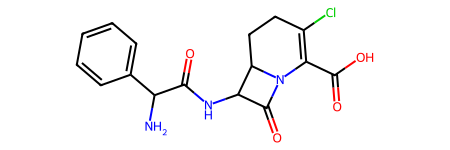

In [69]:
tmp["ROMol"][51]

In [70]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

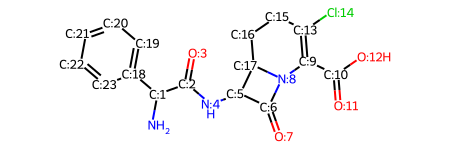

In [71]:
mol_with_atom_index(tmp["ROMol"][51])

In [72]:
print("idx", "rad", "chrg", "deg", "valence", "viol")
for atom in tmp["ROMol"][51].GetAtoms():
    print(f"{atom.GetIdx():3} {atom.GetNumRadicalElectrons():3} {atom.GetFormalCharge():3} {atom.GetTotalDegree():4} {atom.GetTotalValence(): 4} {atom.HasValenceViolation():6}")

idx rad chrg deg valence viol
  0   0   0    3    3      0
  1   0   0    4    4      0
  2   0   0    3    4      0
  3   0   0    1    2      0
  4   0   0    3    3      0
  5   0   0    4    4      0
  6   0   0    3    4      0
  7   0   0    1    2      0
  8   0   0    3    3      0
  9   0   0    3    4      0
 10   0   0    3    4      0
 11   0   0    1    2      0
 12   0   0    2    2      0
 13   0   0    3    4      0
 14   0   0    1    1      0
 15   0   0    4    4      0
 16   0   0    4    4      0
 17   0   0    4    4      0
 18   0   0    3    4      0
 19   0   0    3    4      0
 20   0   0    3    4      0
 21   0   0    3    4      0
 22   0   0    3    4      0
 23   0   0    3    4      0


In [5]:
def calc_pmi(mol, replicates=3):
    npr1 = []
    npr2 = []
    for rdst in [2025 + 3 * i for  i in range(replicates)]:
        m = generate_3d(mol, rdst)  
        if m is not None:
            npr1.append(rdMolDescriptors.CalcNPR1(m))
            npr2.append(rdMolDescriptors.CalcNPR2(m))
        else:
            return None
    return np.median(npr1), np.median(npr2)

In [6]:
def get_pmis(filepath):
    df = pd.read_csv(filepath)
    # if any(x in file for x in ["chembl", "drugbank"]):
    #     df = df.sample(n=5000, random_state=2025)
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol="taut_smiles")
    if len(df) > 1000:
        pandarallel.initialize(nb_workers=6, progress_bar=True)
        res = df["ROMol"].parallel_apply(calc_pmi)
        df[["NPR1", "NPR2"]] = pd.DataFrame(res.tolist(), index=df.index)
    else:
        df[["NPR1", "NPR2"]] = df["ROMol"].apply(calc_pmi).apply(pd.Series)
    cols = [df.columns[0]] + ["NPR1", "NPR2"]
    return df[cols]


In [7]:
def run_calculation(file):
    start = time.time()
    name = file.split("_")[0]
    path = os.path.join(BASE_PATH, "data", "processed", file)
    df = get_pmis(path)
    df.insert(1, "dataset", [name] * len(df))
    df.rename(columns={df.columns[0]: "ID"}, inplace=True)
    df.to_csv(os.path.join(BASE_PATH, "data", "processed", f"PMIs_{name}.csv"),
                index=False)
    end = time.time()

    print(f"Total execution time: {end - start :.2f} s")

In [8]:
run_calculation(files[0])

Total execution time: 10.51 s


In [ ]:
run_calculation(files[1])

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[16:45:43] UFFTYPER: Unrecognized charge state for atom: 3
[16:45:44] UFFTYPER: Unrecognized charge state for atom: 3
[16:45:44] UFFTYPER: Unrecognized charge state for atom: 3
[16:45:44] UFFTYPER: Unrecognized charge state for atom: 3
[16:45:44] UFFTYPER: Unrecognized charge state for atom: 3
[16:45:44] UFFTYPER: Unrecognized charge state for atom: 3
[16:49:41] UFFTYPER: Unrecognized charge state for atom: 3
[16:49:41] UFFTYPER: Unrecognized charge state for atom: 3
[16:49:41] UFFTYPER: Unrecognized charge state for atom: 3
[16:49:42] UFFTYPER: Unrecognized charge state for atom: 3
[16:49:42] UFFTYPER: Unrecognized charge state for atom: 3
[16:49:42] UFFTYPER: Unrecognized charge state for atom: 3
[17:03:39] UFFTYPER: Unrecognized charge state for atom: 9
[17:03:40] UFFTYPER: Unrecognized charge state for atom: 9
[17:03:40] UFFTYPER: Unrecognized charge state for atom: 9
[17:03:40] UFFTYPER: Unrecognized charge state for atom: 9
[17:03:40] UFFTYPER: Unrecognized charge state for atom:

KeyboardInterrupt: 

  File "/tmp/ipykernel_213632/2634781046.py", line 5, in calc_pmi
    m = generate_3d(mol, rdst)
      ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_213632/3174090692.py", line 9, in generate_3d
    id = rdDistGeom.EmbedMolecule(mh, randomSeed=random_state, useRandomCoords=True)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: Embedding cancelled


[08:29:11] UFFTYPER: Unrecognized charge state for atom: 15
[08:29:11] UFFTYPER: Unrecognized charge state for atom: 15
[08:29:11] UFFTYPER: Unrecognized charge state for atom: 15
[08:29:11] UFFTYPER: Unrecognized charge state for atom: 15
[08:29:11] UFFTYPER: Unrecognized charge state for atom: 15
[08:29:11] UFFTYPER: Unrecognized charge state for atom: 15
[08:52:43] UFFTYPER: Unrecognized charge state for atom: 16
[08:52:44] UFFTYPER: Unrecognized charge state for atom: 16
[08:52:44] UFFTYPER: Unrecognized charge state for atom: 16
[08:52:44] UFFTYPER: Unrecognized charge state for atom: 16
[08:52:44] UFFTYPER: Unrecognized charge state for atom: 16
[08:52:44] UFFTYPER: Unrecognized charge state for atom: 16
[10:01:01] UFFTYPER: Unrecognized charge state for atom: 16
[10:01:01] UFFTYPER: Unrecognized charge state for atom: 16
[10:01:02] UFFTYPER: Unrecognized charge state for atom: 16
[10:01:02] UFFTYPER: Unrecognized charge state for atom: 16
[10:01:03] UFFTYPER: Unrecognized charge

In [9]:
from rdkit.Chem import rdDistGeom

ps = rdDistGeom.srETKDGv3()
ps.numThreads = 6
ps.randomSeed = 2025
ps.pruneRmsThresh = 0.5

for m in mols:
    rdDistGeom.EmbedMultipleConfs(m, 100, ps)

[16:48:01] UFFTYPER: Unrecognized charge state for atom: 1


In [ ]:
import numpy as np
from rdkit.Chem import Descriptors3D

res = []
for m in mols:
    confs = m.GetConformers()
    d = []
    for conf in confs:
        d.append([Descriptors3D.NPR1(m, confId=conf.GetId()),
                  Descriptors3D.NPR2(m, confId=conf.GetId())])
    res.append(np.array(d))

In [11]:
res[0].shape

(100, 2)

In [12]:
for r in res:
    print(len(r))

100
20
100
23
100
3


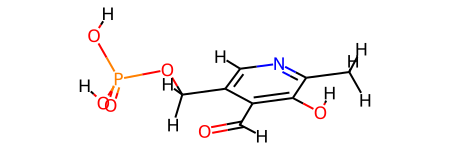

In [13]:
mols[1]

In [18]:
mh = Chem.AddHs(tmp["ROMol"][1])
rdDistGeom.EmbedMolecule(mh, rdDistGeom.srETKDGv3())

0

In [15]:
from rdkit.Chem import rdForceFieldHelpers
s = rdForceFieldHelpers.UFFOptimizeMolecule(mh, maxIters=300)
print(s)

0


In [16]:
s

0

In [ ]:
rdDistGeom.EmbedMultipleConfs(mh, 100, ps)

s2 = rdForceFieldHelpers.UFFOptimizeMoleculeConfs(mh, maxIters=1000, numThreads=6)
for x in s2:
    print(x)

(0, 26.341386369454263)
(0, 25.123093748586438)
(0, 26.34138633303018)
(0, 30.95674841466994)
(0, 27.582007251687628)
(0, 26.851160036601797)
(0, 27.86795888381259)
(0, 28.02262238605056)
(0, 26.362235468277888)
(0, 30.06000350933779)
(0, 28.267056718832666)
(0, 29.098759905133583)
(0, 25.269005992844892)
(0, 29.970325052035427)
(0, 30.471506418680715)
(0, 30.497966024746795)
(0, 27.10322078885603)
(0, 29.19017574115091)
(0, 28.095484530598544)
(0, 30.827100193646338)


In [24]:
s2.index(min(s2))

1

In [25]:
min_val = s2[1][1]

In [31]:
rel_e = []
for i, x in enumerate(s2):
    rel_e.append((i, x[1] - min_val))

In [32]:
sorted(rel_e, key=lambda x: x[1])

[(1, 0.0),
 (12, 0.1459122442584544),
 (2, 1.2182925844437413),
 (0, 1.2182926208678246),
 (8, 1.2391417196914496),
 (5, 1.7280662880153592),
 (16, 1.9801270402695934),
 (4, 2.45891350310119),
 (6, 2.744865135226153),
 (7, 2.8995286374641225),
 (18, 2.9723907820121056),
 (10, 3.1439629702462284),
 (11, 3.9756661565471454),
 (17, 4.0670819925644714),
 (13, 4.847231303448989),
 (9, 4.936909760751352),
 (14, 5.348412670094277),
 (15, 5.374872276160357),
 (19, 5.7040064450599),
 (3, 5.8336546660835005)]